In [28]:
import os

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping

import datetime as dt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import seaborn as sns
#import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [8]:
def load_data(file_name, start_date = "2011-01-01", end_date = "2017-12-31", plot_data=False):
    data = pd.read_csv("D:\\EksploracjaDanych\\bank-share-prices-analysis\\" + file_name)
    data.fillna(0, inplace=True)
    data_trimmed = data[(data["Date"] > start_date) & (data["Date"] < end_date)]
    
    share_prices = np.array(data_trimmed.values[:,1])
    timestamps = np.array([dt.datetime.strptime(d, '%Y-%m-%d').date() for d in data_trimmed.values[:, 0]])
    
    #if plot_data:
    #    plot_share_prices_over_time(timestamps, share_prices, title="Unscaled share prices over time")
    return share_prices, timestamps

In [27]:
def scale_data(share_prices, plot_data):
    scaled_share_prices = SCALER.fit_transform(share_prices.reshape(-1,1)).reshape(1, -1)[0] 
    #if plot_data:
    #    plot_share_prices_over_time(timestamps, scaled_share_prices, title="Scaled share prices over time")
    return scaled_share_prices
    
scaled_share_prices = scale_data(share_prices, plot_data=True)

In [115]:
SCALER = MinMaxScaler()
# DATASETS = USA, GERMANY, BRASIL, NETHERLANDS
DATASET = "NETHERLANDS.csv"
PLOT_DATA = True
n_of_predictions =4
INPUT_TIME_STEPS=10
OUTPUT_TIME_STEPS=5
STATEFUL=False

share_prices, timestamps = load_data(file_name=DATASET, plot_data=True)
smoothed_share_prices = smooth(share_prices, 10)[:len(timestamps)]

Text(0.5, 1.0, 'title')

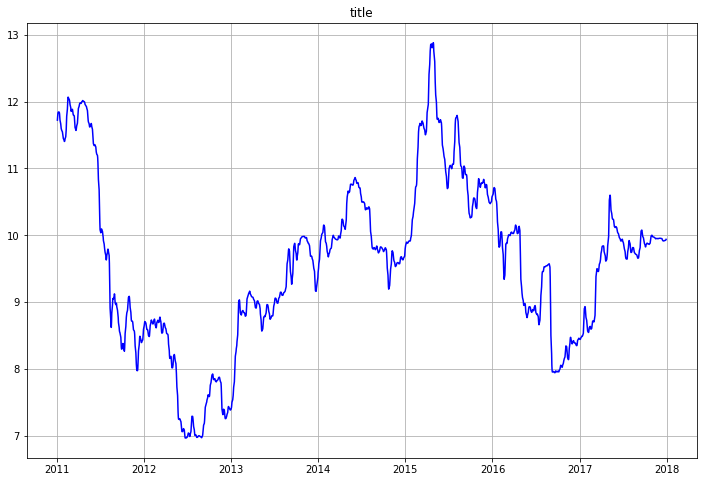

In [116]:
if len(timestamps) < len(smoothed_share_prices):
    smoothed_share_prices = smoothed_share_prices[:len(timestamps)]
else:
    timestamps = timestamps[:len(smoothed_share_prices)]
plt.figure(figsize=(12,8))
plt.plot(timestamps, smoothed_share_prices,'blue', label='Training Data')
plt.grid('Netherlands')
plt.title('title')

In [117]:
quaters = []
dayOfYear = []
dayOfMonth = []
dayOfWeek = []
weekOfYear = []
dates = []
months = []
years = []
dayOfYearCounter = 0
dayOfMonthCounter = 0
dayOfWeekCounter = 0
weekOfYearCounter = 1

for date in timestamps:
    if date.month <= 3:
        quaters.append(1)
    elif date.month >= 3 and date.month <= 6:
        quaters.append(2)
    elif date.month >= 7 and date.month <= 9:
        quaters.append(3)
    elif date.month >= 10 and date.month <= 12:
        quaters.append(4)

    dayOfYearCounter += 1
    dayOfMonthCounter += 1
    dayOfWeekCounter += 1
    dates.append(date)
    months.append(date.month)
    years.append(date.year)
    weekOfYear.append(weekOfYearCounter)
    if dayOfYearCounter != 366:
        dayOfYear.append(dayOfYearCounter)
    else:
        dayOfYearCounter = 1
        dayOfYear.append(dayOfYearCounter)

    if dayOfWeekCounter != 8:
        dayOfWeek.append(dayOfWeekCounter)
    else:
        weekOfYearCounter += 1
        dayOfWeekCounter = 1
        dayOfWeek.append(dayOfWeekCounter)

df= pd.DataFrame()
#df['Values'] = values
#df['Date'] = dates
df['DayOfWeek'] = dayOfWeek
df['Quaters'] = quaters
df['months'] = months
df['years'] = years
df['DayOfYear'] = dayOfYear
df['weekOfYear'] = weekOfYear

In [118]:
# dividing datasets into 0.7(train) and 0.3(test)

if ((0.9* len(smoothed_share_prices)) - int(0.7* len(smoothed_share_prices))) >= 0.5:
    x =int(0.9* len(smoothed_share_prices)) + 1
    y = int(0.1*len(smoothed_share_prices))
else:
    x =int(0.9* len(smoothed_share_prices)) 
    y = int(0.1*len(smoothed_share_prices)) + 1   


y_train = share_prices[:x]
y_test = share_prices[x:]
train_df = df[:x].copy()
test_df = df[x:].copy()
train_df_smoothed = df[:x].copy()
test_df_smoothed = df[x:].copy()
train_df_scaled = df[:x].copy()
test_df_scaled = df[x:].copy()
y_train_smoothed = share_prices[:x]
y_test_smoothed = share_prices[x:]

y_train_scaled = scaled_share_prices[:x]
y_test_scaled = scaled_share_prices[x:]


In [119]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(train_df, y_train,
        eval_set=[(train_df, y_train), (test_df, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[21:47:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [120]:
reg_scaled = xgb.XGBRegressor(n_estimators=1000)
reg_scaled.fit(train_df, y_train_scaled,
        eval_set=[(train_df, y_train_scaled), (test_df, y_test_scaled)],
        early_stopping_rounds=50,
       verbose=False)

[21:47:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBoostError: [21:47:38] src/metric/elementwise_metric.cu:326: Check failed: preds.Size() == info.labels_.Size() (178 vs. 149) : label and prediction size not match, hint: use merror or mlogloss for multi-class classification

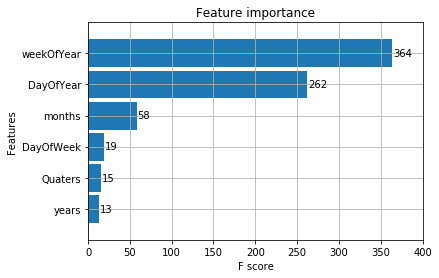

In [109]:
_ = plot_importance(reg, height=0.9)

In [114]:
test_df['MW_Prediction'] = reg.predict(test_df)
test_df_scaled['MW_Prediction'] = reg_scaled.predict(test_df_scaled)

ValueError: feature_names mismatch: ['DayOfWeek', 'Quaters', 'months', 'years', 'DayOfYear', 'weekOfYear'] ['DayOfWeek', 'Quaters', 'months', 'years', 'DayOfYear', 'weekOfYear', 'MW_Prediction']
training data did not have the following fields: MW_Prediction

In [111]:
reg_smoothed = xgb.XGBRegressor(n_estimators=1000)
reg_smoothed.fit(train_df_smoothed, y_train_smoothed,
        eval_set=[(train_df_smoothed, y_train_smoothed), (test_df_smoothed, y_test_smoothed)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train
test_df_smoothed['MW_Prediction'] = reg_smoothed.predict(test_df_smoothed)

[21:46:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0.5, 1.0, 'title')

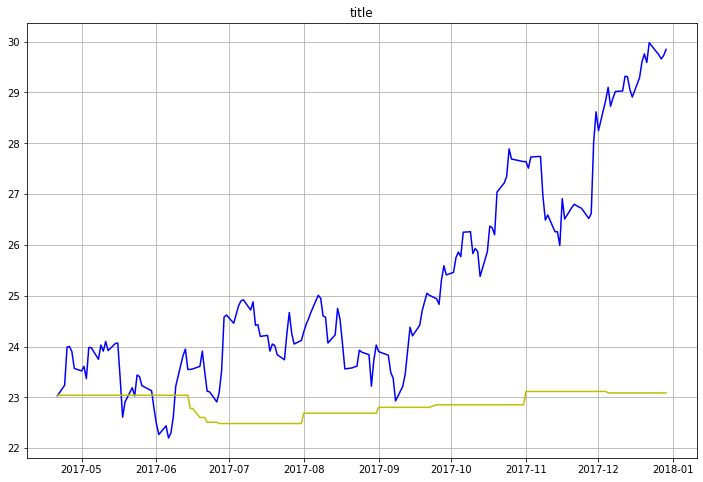

In [112]:

plt.figure(figsize=(12,8))
#plt.plot(xgboost_test_timestamps, test_df['MW_Prediction'],'r')
plt.plot(timestamps[x:], y_test, 'b')
plt.plot(timestamps[x:], test_df_smoothed['MW_Prediction'], 'y')
plt.grid('Netherlands')
plt.title('title')